In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt

## torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


import torch.distributed as dist
## Torchvision
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset , random_split
import torchvision.models as models



DATASET_PATH = "./data"
random.seed(42)
#Device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Device: cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
project_path = '/content/drive/My Drive/self_supervised_learning'
os.chdir(project_path)

print("Current directory:", os.getcwd())

Current directory: /content/drive/My Drive/self_supervised_learning


In [4]:
from files.models import *

#### Data Preparation : Partionning & preprocesing

## **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.


In [5]:
# Transform to normalized Tensors in the range [0,1]

transform = T.Compose([T.Pad(2) #to cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).
                       , T.ToTensor(), T.Normalize((0.5,), (0.5,))])

In [6]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=transform)
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=transform)

In [7]:
MNIST_train_dataset, MNIST_test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

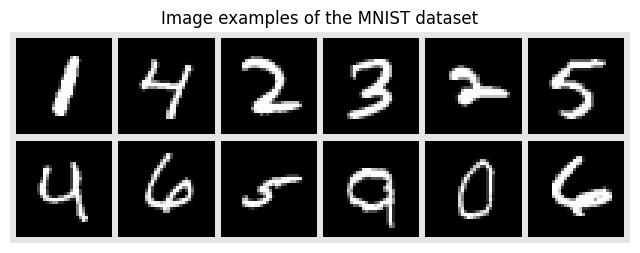

In [8]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [9]:
# use DataLoader to keep applied transformation when download the data..

MNIST_train_loader = torch.utils.data.DataLoader(MNIST_train_dataset, batch_size=64, shuffle=True)
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=64, shuffle=False)
# help(MNIST_train_loader)
#check stats :
data_iter = iter(MNIST_train_loader)
images, labels = next(data_iter)

mean = images.mean()
std = images.std()
min_val = images.min()
max_val = images.max()

print(f'Batch Mean: {mean.item()}')
print(f'Batch Std: {std.item()}')
print(f'Batch Min: {min_val.item()}')
print(f'Batch Max: {max_val.item()}')

Batch Mean: -0.7984845638275146
Batch Std: 0.5515456199645996
Batch Min: -1.0
Batch Max: 1.0


In [10]:
train_images, train_labels = next(iter(MNIST_train_loader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


#### Baseline Model Setup : extent with limited labeled data

In [11]:
indices = np.random.permutation(len(MNIST_train_dataset))[:100]
train_100= Subset(MNIST_train_dataset, indices)


In [12]:
train_100_loader = DataLoader(train_100, batch_size=10, shuffle=True)

In [13]:
image, label = train_100[0]
image.shape, label


(torch.Size([1, 32, 32]), 9)

In [14]:
model = Basic_CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_100_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_100_loader):.4f}")

Epoch [1/10], Loss: 2.7447
Epoch [2/10], Loss: 2.1155
Epoch [3/10], Loss: 1.5540
Epoch [4/10], Loss: 1.1238
Epoch [5/10], Loss: 0.8090
Epoch [6/10], Loss: 0.5832
Epoch [7/10], Loss: 0.4504
Epoch [8/10], Loss: 0.3289
Epoch [9/10], Loss: 0.2592
Epoch [10/10], Loss: 0.1955


In [16]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in MNIST_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set (10K): {100 * correct / total:.2f}%")

Accuracy on the test set (10K): 79.11%


MoCo was implemented on RGB ImageNet data with and ResNet encoder

* modify MoCo loader to handle our data
* configuration (explore light encoder beside resnet(mnist is too simple than imageNet))

In [17]:
!git clone https://github.com/facebookresearch/moco.git


fatal: destination path 'moco' already exists and is not an empty directory.


In [18]:
%ls moco

detection/  LICENSE  main_lincls.py  main_moco.py  moco/  README.md


In [19]:
import sys
sys.path.append(os.path.abspath('./moco'))

print("Python path:", sys.path)

Python path: ['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/tmp/tmpwy324ovc', '/content/drive/My Drive/self_supervised_learning/moco']


In [20]:
from moco.loader import TwoCropsTransform

In [21]:
batch_size = 8
nb_workers = 2

In [22]:
base_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.RandomResizedCrop(128, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Apply TwoCropsTransform
Moco_train_transform = TwoCropsTransform(base_transform)

In [23]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train=True, download=True, transform=Moco_train_transform)


all_indices = np.arange(len(MNIST_train_dataset))
rest_indices = np.setdiff1d(all_indices, indices) #indices are the 100 indices labeled
train_unlabeled = Subset(MNIST_train_dataset, rest_indices)

train_loader = DataLoader(train_unlabeled, batch_size=batch_size, shuffle=True, num_workers=nb_workers, pin_memory=True)


In [24]:
# print(dir(models))


In [25]:
from moco.builder import MoCo

In [31]:
model = MoCo(
    base_encoder=models.resnet18,
    dim=128,
    K=4096,
    m=0.99,
    T=0.07
)
model = model.to(device)

In [32]:
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0001)

def train(model, data_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for (images, labels) in data_loader:  # images contains [im_q, im_k]
            # print(f"im_q shape: {images[0].shape}, im_k shape: {images[1].shape}")
            # print(f"Labels shape: {labels.shape}")
            # break
            im_q, im_k = images  # Unpack the two augmented views
            im_q, im_k = im_q.to(device), im_k.to(device)
            labels = labels[:len(im_q)].to(device)

            # Forward pass
            output, target = model(im_q=im_q, im_k=im_k)  # Pass both query and key
            loss = criterion(output, target)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

def evaluate(model, data_loader):
    model.eval()
    with torch.no_grad():
        correct = total = 0
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on test images: {100 * correct / total}%')


In [33]:
train(model, train_loader, optimizer, epochs=10)

ValueError: Default process group has not been initialized, please make sure to call init_process_group.